# Predicting the outcomes of NBA games

There have been many projects done attempting to predict the final score of various sports games. Normally, they set out with the goal of gaining some sort of insight about the outcome of the game prior to the game starting. While that was initially one of our ideas, we choose a slightly different route. We decided to try to develop some sort of insight about the outcome DURING the game. 

Our goal was to be able to create a model that uses data collected at half-time of an NBA game and predict the final score. The motivation we had was to create a model that could potentially be useful in live betting on NBA games, and to potentially develop some sort of insight that could be used by teams to enhance their performance.

The end-goal would be to create a web application were you can either manually input halftime data, or be able to select a live matchup that is at halftime and output a predicted final score. 

# The Data



In [2]:
# importing necessary packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 500)
%matplotlib inline

In [3]:
# loaidng in the dataset into a Pandas Dataframe
all_games = pd.read_csv('updated_nba_half_stats.csv')
all_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14614 entries, 0 to 14613
Data columns (total 89 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   GAME_ID         14614 non-null  int64  
 1   Date            14614 non-null  object 
 2   Matchup         14614 non-null  object 
 3   h_E_OFF_RATING  14258 non-null  float64
 4   h_OFF_RATING    14258 non-null  float64
 5   h_E_DEF_RATING  14258 non-null  float64
 6   h_DEF_RATING    14258 non-null  float64
 7   h_E_NET_RATING  14258 non-null  float64
 8   h_NET_RATING    14258 non-null  float64
 9   h_AST_PCT       14258 non-null  float64
 10  h_AST_TOV       14258 non-null  float64
 11  h_AST_RATIO     14258 non-null  float64
 12  h_OREB_PCT      9823 non-null   float64
 13  h_DREB_PCT      9883 non-null   float64
 14  h_REB_PCT       7503 non-null   float64
 15  h_E_TM_TOV_PCT  14258 non-null  float64
 16  h_TM_TOV_PCT    14258 non-null  float64
 17  h_EFG_PCT       14258 non-null 

### Missing Data
The data set we obtained is for the most part free of missing data. Columns that concern rebounding percentage have the most missing data. This is because the NBA started recording rebounding percentage in 1970, nearly 20 years after they started recording stats. To remedy this, we can just drop those columns. The stat is largely derived from the total rebounds which doesn't have missing data so we won't lose very much information by dropping these columns.

There is another set of columns that are mssing about 300 data points. Because this is such a small percentage of the data, I can drop these rows that are missing. In the results above, you can see that a majority of rows have 14683 entries, and all the ones missing a few hundred have exactly 14325. Because they are missing the same amount of data, I'm going to assume they are from the same rows and remove those rows. If they aren't from the same rows, I may end up having to remove more rows than I'd like and will have to look into some tools to infer the data points.

In [4]:
# Removing missing rebounding percentage data
all_games = all_games.drop(['h_OREB_PCT', 'h_DREB_PCT', 'h_REB_PCT','a_OREB_PCT', 'a_DREB_PCT', 'a_REB_PCT'],\
                           axis=1)
all_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14614 entries, 0 to 14613
Data columns (total 83 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   GAME_ID         14614 non-null  int64  
 1   Date            14614 non-null  object 
 2   Matchup         14614 non-null  object 
 3   h_E_OFF_RATING  14258 non-null  float64
 4   h_OFF_RATING    14258 non-null  float64
 5   h_E_DEF_RATING  14258 non-null  float64
 6   h_DEF_RATING    14258 non-null  float64
 7   h_E_NET_RATING  14258 non-null  float64
 8   h_NET_RATING    14258 non-null  float64
 9   h_AST_PCT       14258 non-null  float64
 10  h_AST_TOV       14258 non-null  float64
 11  h_AST_RATIO     14258 non-null  float64
 12  h_E_TM_TOV_PCT  14258 non-null  float64
 13  h_TM_TOV_PCT    14258 non-null  float64
 14  h_EFG_PCT       14258 non-null  float64
 15  h_TS_PCT        14258 non-null  float64
 16  h_USG_PCT       14258 non-null  float64
 17  h_E_USG_PCT     14258 non-null 

In [5]:
# Removing rows with just a few hundred missing points
all_games = all_games[all_games['a_PLUS_MINUS'].notna()]
all_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14258 entries, 0 to 14613
Data columns (total 83 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   GAME_ID         14258 non-null  int64  
 1   Date            14258 non-null  object 
 2   Matchup         14258 non-null  object 
 3   h_E_OFF_RATING  14258 non-null  float64
 4   h_OFF_RATING    14258 non-null  float64
 5   h_E_DEF_RATING  14258 non-null  float64
 6   h_DEF_RATING    14258 non-null  float64
 7   h_E_NET_RATING  14258 non-null  float64
 8   h_NET_RATING    14258 non-null  float64
 9   h_AST_PCT       14258 non-null  float64
 10  h_AST_TOV       14258 non-null  float64
 11  h_AST_RATIO     14258 non-null  float64
 12  h_E_TM_TOV_PCT  14258 non-null  float64
 13  h_TM_TOV_PCT    14258 non-null  float64
 14  h_EFG_PCT       14258 non-null  float64
 15  h_TS_PCT        14258 non-null  float64
 16  h_USG_PCT       14258 non-null  float64
 17  h_E_USG_PCT     14258 non-null 

As I suspected the rows with just a few hundred missing data points were from the same row. The dataset now contains 81 columns and 14325 entries, with no mssing values. Now we can move forward with some data visualization to get an initial understanding about relationships present in the data.

# Data Visualization

The goal for this process of data visualization is to first see if there are any underlying relationships that are present in our data. This will make the process of constructing models much more effiecient. I will also look out for statistics that have no effect on final score. If a column adds little to no information, it won't provide any value if trained on by a model. Therefore it wouldn't make sense to keep and we can drop the statistic.

Something else that we will look into is if there is any correlation between one team's final score, and any of the opposing team's statistics. An example of this would be if the home team's final score is affected by the away team's number of turnovers. The reason this is important is that if that if there are no strong correlations, we will be able to effectively double the amount of data we have by splitting up the data into home and away statistics, then appending one to another and adding an extra column indicating whether or not they are the home team. If we are able to do this, we will have twice as many rows which could give our models more data to train and test on. 

The first thing I will look at is a heat map of the correlations each column has to one another. This will give me ideas of what I need to look into.

<Figure size 1440x1440 with 0 Axes>

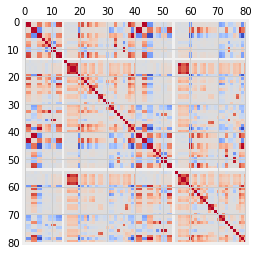

In [6]:
corr = all_games.corr()
plt.figure(figsize=(20, 20))
plt.matshow(corr, cmap='coolwarm')
plt.savefig("heatmap.png")
# corr.style.background_gradient(cmap='coolwarm')

In [7]:
# dropping h_USG_PCT and a_USG_PCT that have the same value for each row.
all_games = all_games.drop(['h_USG_PCT', 'a_USG_PCT'], axis=1)

In [8]:
h = corr['h_final_PTS']
a = corr['a_final_PTS']

pd.concat([h, a], axis=1).T

,GAME_ID,h_E_OFF_RATING,h_OFF_RATING,h_E_DEF_RATING,h_DEF_RATING,h_E_NET_RATING,h_NET_RATING,h_AST_PCT,h_AST_TOV,h_AST_RATIO,h_E_TM_TOV_PCT,h_TM_TOV_PCT,h_EFG_PCT,h_TS_PCT,h_USG_PCT,h_E_USG_PCT,h_E_PACE,h_PACE,h_PACE_PER40,h_POSS,h_PIE,h_FGM,h_FGA,h_FG_PCT,h_FG3M,h_FG3A,h_FG3_PCT,h_FTM,h_FTA,h_FT_PCT,h_OREB,h_DREB,h_REB,h_AST,h_STL,h_BLK,h_TO,h_PF,h_half_PTS,h_PLUS_MINUS,h_final_PTS,a_E_OFF_RATING,a_OFF_RATING,a_E_DEF_RATING,a_DEF_RATING,a_E_NET_RATING,a_NET_RATING,a_AST_PCT,a_AST_TOV,a_AST_RATIO,a_E_TM_TOV_PCT,a_TM_TOV_PCT,a_EFG_PCT,a_TS_PCT,a_USG_PCT,a_E_USG_PCT,a_E_PACE,a_PACE,a_PACE_PER40,a_POSS,a_PIE,a_FGM,a_FGA,a_FG_PCT,a_FG3M,a_FG3A,a_FG3_PCT,a_FTM,a_FTA,a_FT_PCT,a_OREB,a_DREB,a_REB,a_AST,a_STL,a_BLK,a_TO,a_PF,a_half_PTS,a_PLUS_MINUS,a_final_PTS
h_final_PTS,-0.035935,0.598009,0.599434,0.114691,0.111892,0.353146,0.356158,0.090915,0.244329,0.352857,-0.193115,-0.192930,0.538911,0.561309,NaN,0.004829,0.412596,0.353706,0.353706,0.424489,0.338426,0.610402,0.284379,0.475874,0.470476,0.367579,0.283293,0.217267,0.187278,0.110534,-0.021002,0.138122,0.103686,0.446918,0.068882,0.034738,-0.089776,0.063934,0.732786,0.359563,1.000000,0.113837,0.107503,0.598009,0.594140,-0.353683,-0.355991,-0.002233,0.032728,0.043169,-0.060823,-0.064567,0.110331,0.121241,NaN,0.003804,0.412588,0.357639,0.357640,0.421558,-0.339390,0.205245,0.240000,0.068482,0.205775,0.255467,0.043930,0.106111,0.090771,0.052585,-0.029488,-0.177945,-0.166656,0.125540,-0.053327,-0.126905,0.022266,0.148037,0.275113,-0.359255,0.425491
a_final_PTS,-0.026748,0.122315,0.117049,0.598079,0.600835,-0.351706,-0.357892,-0.019262,0.021809,0.026284,-0.045714,-0.048272,0.129533,0.143106,NaN,0.013073,0.404477,0.368386,0.368387,0.413740,-0.342099,0.197067,0.212844,0.076353,0.236264,0.281607,0.055307,0.114834,0.101163,0.052914,-0.048449,-0.170110,-0.171380,0.105664,-0.082719,-0.104820,0.039743,0.140882,0.281444,-0.358887,0.425491,0.598799,0.605990,0.122304,0.125172,0.352222,0.356546,0.082401,0.262926,0.355869,-0.226450,-0.221700,0.530593,0.557038,NaN,0.004940,0.405923,0.274755,0.274757,0.418750,0.343131,0.616979,0.301957,0.476176,0.459048,0.355696,0.291819,0.211393,0.170993,0.137122,-0.041178,0.123108,0.078752,0.446923,0.071749,0.004341,-0.122084,0.072190,0.733331,0.357116,1.000000


There are a lot of complexities in the data. A lot of the variables are derived from different combinations of other variables. For example, `h_OFF_RATING` is strongly correlated to `h_final_PTS` but since it is derived from an equation that involves in one way or another all the shooting percentages and total points, it is even more correlated to some of the base stats such as `h_FG_PCT` and `h_half_PTS`. To investigate these correlaitons in more depth, we will look through some scatter plots and determine which variables are the most important to use to train the data. 

First, I will use an interactive graph that will allow me to quickly switch between various variables to see if there are relationships. Whenever I find some sort of meaningful relationship, I will look more into it using other types of graphs.

In [11]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def stat(stat1, stat2, bestfit):
    plt.style.use('fivethirtyeight')
    all_games.plot(x=stat1, y=stat2, style='o', figsize=(8,8))
    plt.ylabel(stat2)
    plt.title("{} vs {}".format(stat1, stat2))
    if bestfit:
        m, b = np.polyfit(all_games[stat1], all_games[stat2], 1)
        plt.plot(all_games[stat1], m * (all_games[stat1]) + b)
    plt.show()

_ = interact(stat,
             stat1 = widgets.Dropdown(options=all_games.columns, value='h_half_PTS'),
             stat2 = widgets.Dropdown(options=all_games.columns, value='h_final_PTS'),
             bestfit = widgets.Dropdown(options=[True, False], value=True)
            )

    

interactive(children=(Dropdown(description='stat1', index=39, options=('GAME_ID', 'Date', 'Matchup', 'h_E_OFF_…

## Examining Multicollinearity
The following graphs will look at mulitcollinearity amongst various statistics that could help reduce the amount of unnecessary columns. This could also lead to some sort of insight that could assist in model creation.

_Note: As we go about this process of EDA, we are printing some graphs that may have exemplified a certain point we were trying to make. These were not the only graphs we looked at. We looked through many through the interactive graph above to help get a quick view of what was going on._

Text(0.5, 1.0, 'h_OFF_RATING vs. h_TS_PCT')

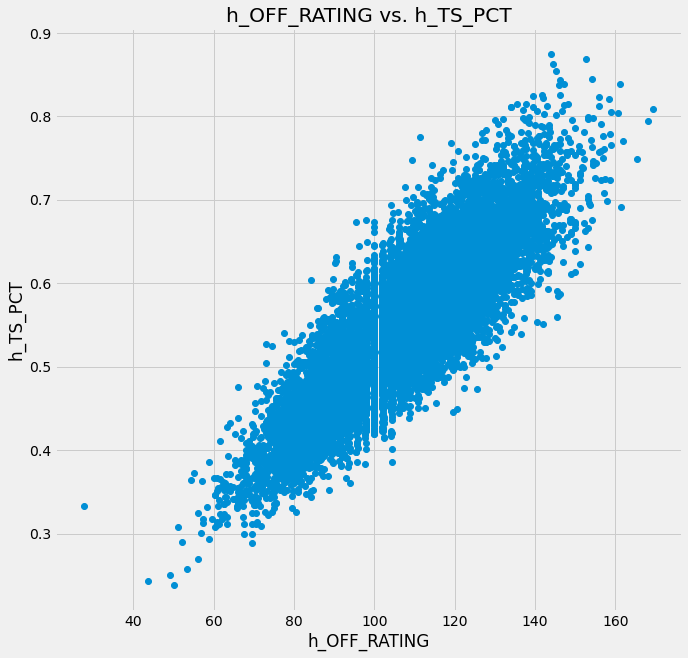

In [10]:
all_games.plot(x='h_OFF_RATING', y='h_TS_PCT', style='o', figsize=(10,10), legend=None)
plt.ylabel('h_TS_PCT')
plt.title('h_OFF_RATING vs. h_TS_PCT')

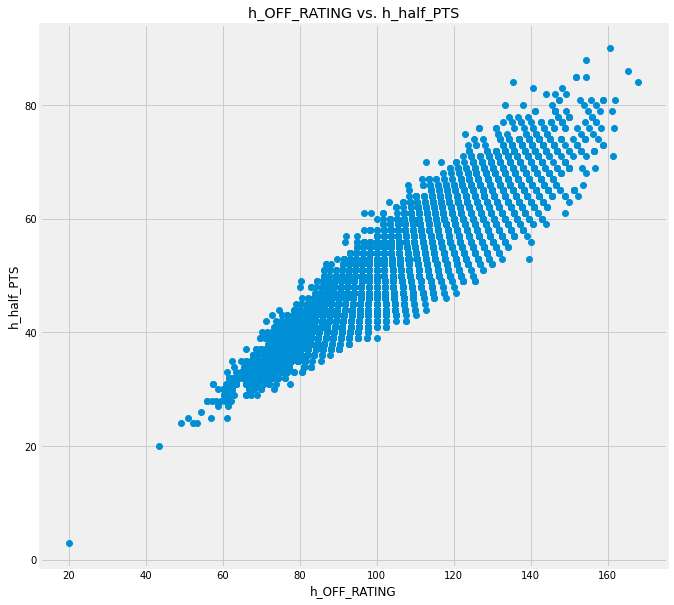

In [26]:
all_games.plot(x='h_OFF_RATING', y='h_half_PTS', style='o', figsize=(10,10), legend=None)
plt.ylabel('h_half_PTS')
plt.title('h_OFF_RATING vs. h_half_PTS')
plt.savefig("OFF_rating_vs_half_PTS.png")

## Results of Multicolinearity 
It became evident that many of the statistics we were able to gather data on were related to each other in some form or another. Through these scatter plots it is easy to confirm our suspicious developed from the heatmap. 

#### A Decision
There seemed to be a decision to make. Either using the advanced or derived statistics such as `h_OFF_RATING` and `h_AST_RATIO` or using more base stats such as `h_FGM` and `h_REB`. It would not make sense to use both because they contain similar information and would be redundant.

There were tradeoffs to each of them. Both groups of statistics have some sort of correlation to final score. However, the correlations are generally stronger on the derived statistics. Our hypothesis on why this is, is that these statisitcs were derived for the very purpose of giving some sort of insight to the game. `h_OFF_RATING` for example is meant to give insight into the performance of the offense as a whole, where an individual statistic like `h_FGA` will only give insight on how many times the home team has shot. This comes at the tradeoff that there are fewer of these derived statistics. This could also be a pro if it helped train our model to similar accuracy with less data. 

Using base statistics also has its benefits. First off, there are more of them that have a significant degree of correlation than the derived statistics. This could give our model more data points to train on. There could also be an advantage when it comes to inputting the data once we have a trained model. One of our end goals is to deploy the model using onto the web so that it is usable. Our options are to manually input the data or find a way to get live data during halftime of a desired games. It would be easier on the user to input base statistics which can easily be found on the box score of a game. While it would be doable to have the user input base statistics and derive the statistics ourselves, oftentimes, they are derived on other derived statistics which could greatly complicate the process of inputting data. So if there is little to no accuracy gained by using derived statistics to create a model, then perhaps it would make more sense to just use base statistics. 

#### The Choice
After some testing with various combinations of derived statistics and various combinations of base statistics, models trained on base statistics tend to perform more consistently. Because of this, we choose to implement a model using base statistics.

After testing models the best combination of base statistics turned out to be all of them except the `REB` because it was accounted for in `OREB` and `DREB`. More on the exact parameters later on. 


## Correlations to Final Score
Now we will look into various statistics correlation to `h_final_PTS` and `a_final_PTS`. This will help us find the columns that add the most accuracy to the model. 

Text(0.5, 1.0, 'h_half_PTS vs. h_final_PTS')

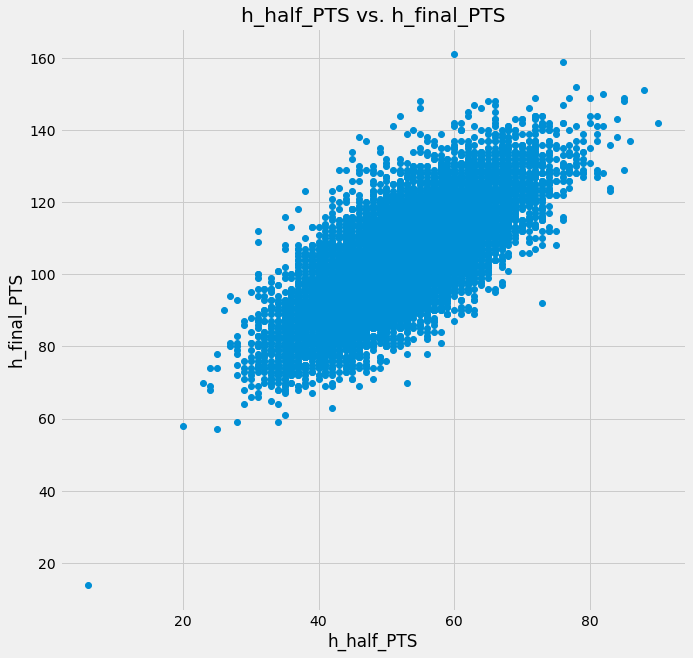

In [12]:
all_games.plot(x='h_half_PTS', y='h_final_PTS', style='o', figsize=(10,10), legend=None)
plt.ylabel('h_final_PTS')
plt.title('h_half_PTS vs. h_final_PTS')

Text(0.5, 1.0, 'h_FGA vs. h_final_PTS')

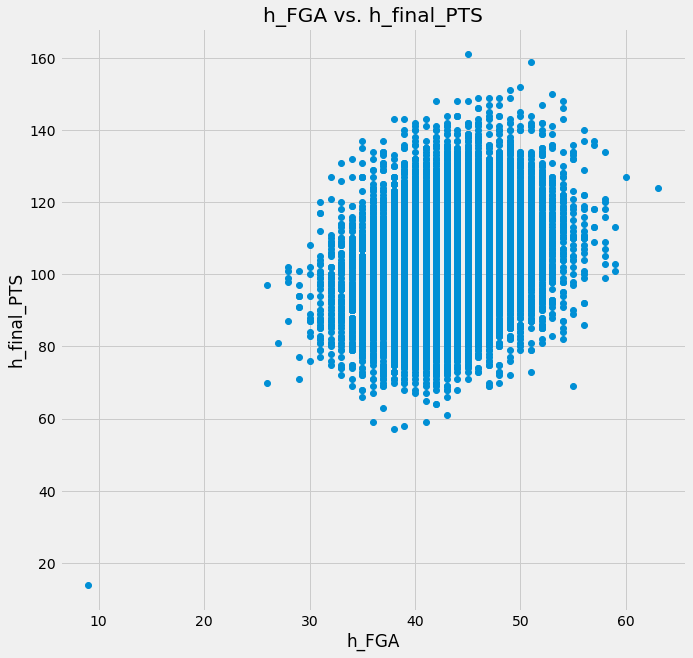

In [14]:
all_games.plot(x='h_FGA', y='h_final_PTS', style='o', figsize=(10,10), legend=None)
plt.ylabel('h_final_PTS')
plt.title('h_FGA vs. h_final_PTS')

Text(0.5, 1.0, 'h_FGM vs. h_final_PTS')

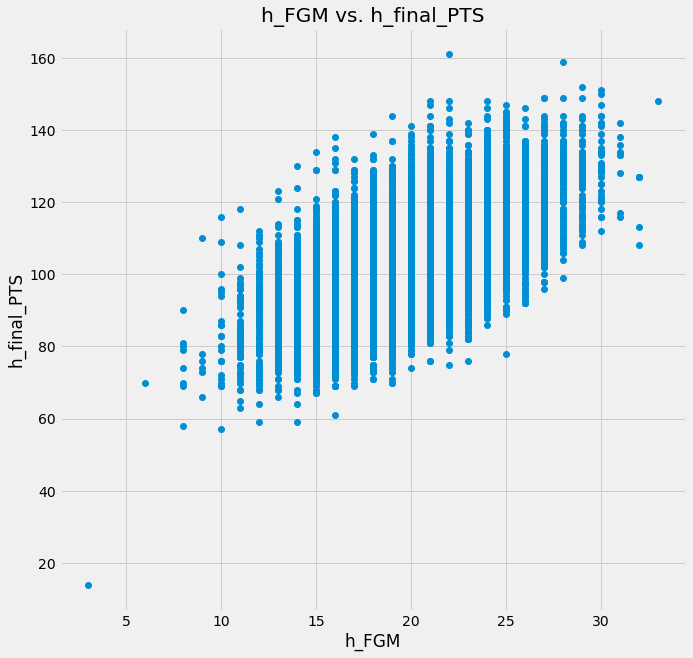

In [15]:
all_games.plot(x='h_FGM', y='h_final_PTS', style='o', figsize=(10,10), legend=None)
plt.ylabel('h_final_PTS')
plt.title('h_FGM vs. h_final_PTS')

Text(0.5, 1.0, 'h_TO vs. h_final_PTS')

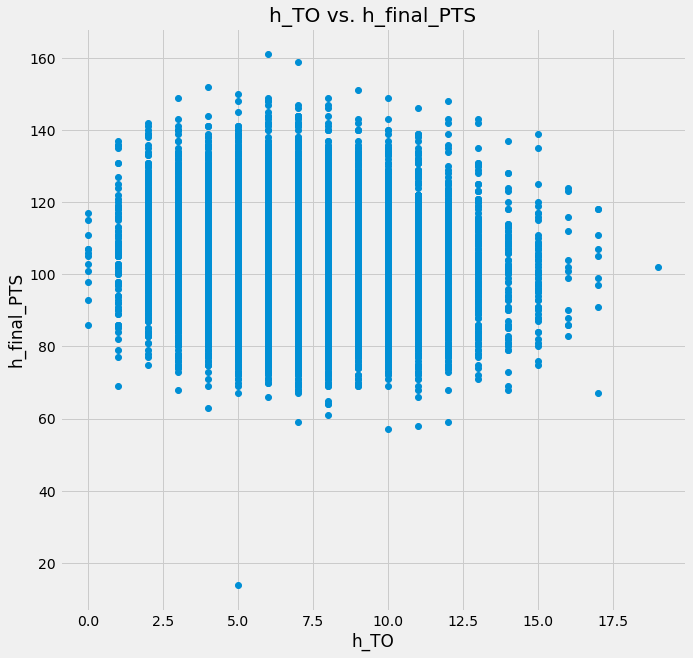

In [16]:
# checking our scatterplot of a statistic with a small correlation coefficient
all_games.plot(x='h_TO', y='h_final_PTS', style='o', figsize=(10,10), legend=None)
plt.ylabel('h_final_PTS')
plt.title('h_TO vs. h_final_PTS')

Text(0.5, 1.0, 'h_PF vs. h_final_PTS')

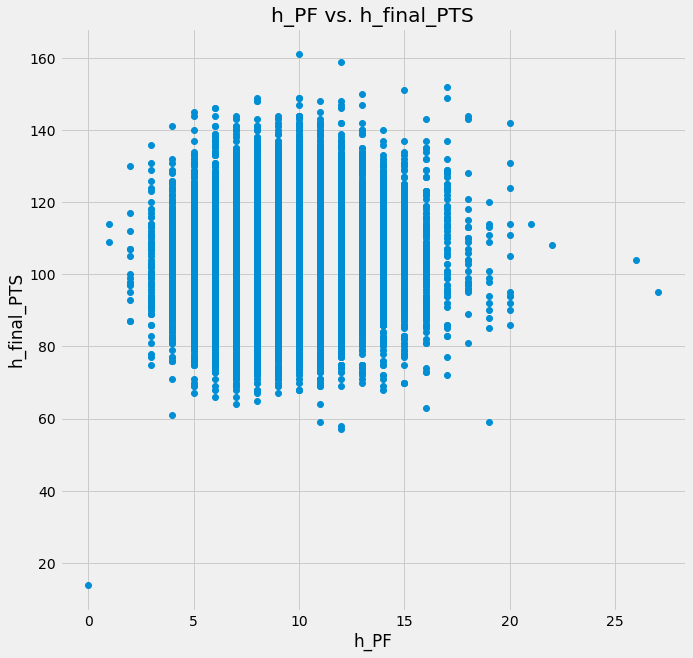

In [17]:
all_games.plot(x='h_PF', y='h_final_PTS', style='o', figsize=(10,10), legend=None)
plt.ylabel('h_final_PTS')
plt.title('h_PF vs. h_final_PTS')

## Correlation to Final Score results
After looking deeper into the relationships between final scores our suspicions from the heatmap were confirmed once again. Some columns that had high correlation were `h_half_PTS`, `h_FGM` and `h_AST`. A few that seemed to have little to no correlation were `h_PF` and `h_TO`.

## Doubling the data
Notice that we've only been looking into data about the home team denoted by the prefix `h_` before each statistic. This is not without reasoning. After looking into multicollinearity, I noticed that most of opposing teams statistics from each game were correlated to each other. So the idea came to split the data set down the middle by home and away statistics, then append home statistics to away statistics. Essentially halving the number of columns and doubling the number of rows of the data. If the other teams statistics add no value to the predicted score then we would be able to double the amount of data available to train a model with. 

To see if this is reasonable, we will investigate how final score is correlated to opposing teams statistics. 
If opposing teams statistics are not correlated or, if they are correlated but strongly correlated to an opposing teams stat then this idea will be put in to action.

Text(0.5, 1.0, 'a_FGM vs. h_final_PTS')

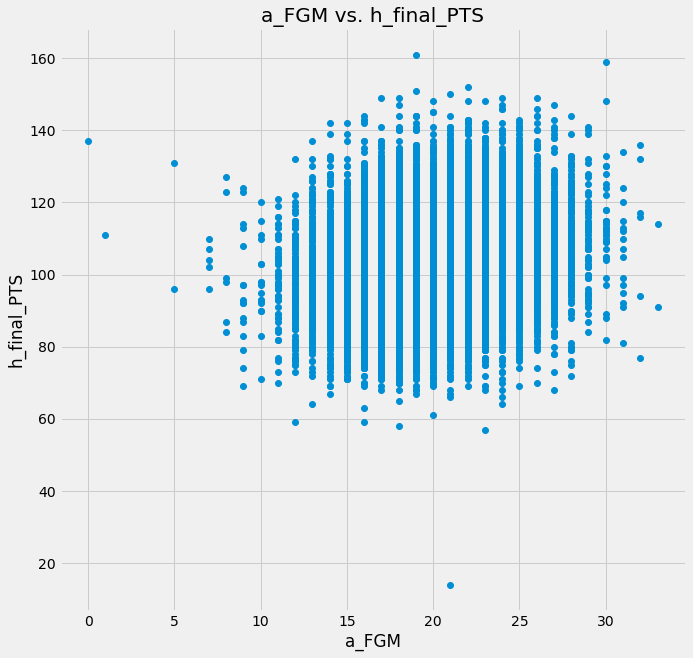

In [18]:
all_games.plot(x='a_FGM', y='h_final_PTS', style='o', figsize=(10,10), legend=None)
plt.ylabel('h_final_PTS')
plt.title('a_FGM vs. h_final_PTS')

Text(0.5, 1.0, 'a_TO vs. h_final_PTS')

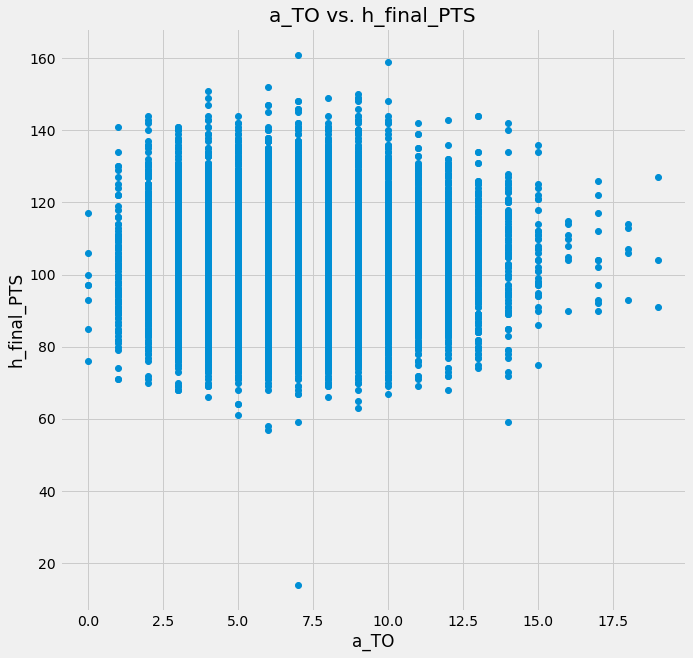

In [19]:
all_games.plot(x='a_TO', y='h_final_PTS', style='o', figsize=(10,10), legend=None)
plt.ylabel('h_final_PTS')
plt.title('a_TO vs. h_final_PTS')

## Doubling the Data Verdict
After looking into correlation between opposing teams statistics, there is little evidence of an opposite teams statistic adding any information about final score. So we will go forward with this process of doubling the rows and halving the columns in our data.

Below we will execute this and save a new csv to use when training our model. Note that many columns were removed due to multicollinearity discussed earlier. 

In [22]:
labels = ['OFF_RATING', 'DEF_RATING', 'NET_RATING', 'AST_RATIO', 'TS_PCT', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'AST', 'STL', 'BLK', 'TO',
          'PF', 'half_PTS', 'final_PTS']
a_labels = ['a_'+label for label in labels]
h_labels = ['h_'+label for label in labels]
new_labels = ['OFF_RATING', 'DEF_RATING', 'NET_RATING', 'AST_RATIO', 'TS_PCT','FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'AST', 'STL', 'BLK', 'TO',
          'PF', 'half_PTS', 'final_PTS', 'Home']
a_games = all_games[a_labels]
a_games['Home_team'] = 0
a_games.columns = new_labels
h_games = all_games[h_labels]
h_games['Home_team'] = 1
h_games.columns = new_labels
games = h_games.append(a_games)
# games.to_csv('./gamesDoubled.csv')

<ipython-input-22-412f7155062e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a_games['Home_team'] = 0
<ipython-input-22-412f7155062e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_games['Home_team'] = 1


## Concluding Thoughts
After this process of data analysis, we realized that there are 2 classes of data with strong correlation to final score. These were discussed earlier and they are the derived statistics and the base statistics. It is hard to tell which will train the better models. To figure this out, we empirically tested models trained on various combinations. 

### Spoiler Alert:
After the empirical testing above, the most consistent results produced were from a model trained with the following statistics. `['FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'half_PTS', 'Home']` 

Despite a few of these having little correlation to final score, removing each seemed to decrease the accuracy of the model by a little. Since we had the data available we just trained the model on all of these to make sure we got the highest accuracy possible. Using the base statistics as we've been calling them has the added benefit of ease of implementation for when we deploy our model. 